In [1]:
import requests
import json
import xmltodict
import urllib.parse
import opencitingpy
import datetime
import sqlite3
import os
from matplotlib import pyplot as plt
import numpy as np
import re
import math
import ipywidgets as widgets
from IPython.display import display, clear_output
import re 

import xml.etree.ElementTree as ET
from collections import Counter

In [2]:
# Anlegen von Datenbankspeicherort, falls er nicht existiert
path = "C:\MA_Pethke_3992454"
if not os.path.exists(path):
    os.makedirs(path)

# Verbindung zu DB aufbauen, DB wird automatisch erstellt, wenn keine da ist
con = sqlite3.connect("C:\MA_Pethke_3992454\MA_3992454_idea_2.db")
cur = con.cursor()

In [3]:
## Tabellen Schema erstellen
#------------------- Tabelle Dokument --------------------------------------#
cur.execute("CREATE TABLE IF NOT EXISTS Dokumente(PMID INTEGER UNIQUE, titel TEXT, pubyear YEAR)")

#------------------- Tabelle Zitationen --------------------------------------#
cur.execute("CREATE TABLE IF NOT EXISTS Zitationen(PMID INTEGER, Jahr YEAR, Anzahl INETEGER)")

#------------------- Tabelle Mesh --------------------------------------#
cur.execute("CREATE TABLE IF NOT EXISTS Mesh(UI VARCHAR UNIQUE, name TEXT, jahr YEAR)")

#------------------- Tabelle Mesh - PMID --------------------------------------#
cur.execute("CREATE TABLE IF NOT EXISTS Mesh_PMID(UI VARCHAR, PMID INTEGER)")
con.commit()

In [10]:
##  INSERT DB

def insertMeshData_db(meshUI_loc, meshTerm_loc, meshDate_loc):
    print("Das ausgewählte MeSH " + str(meshUI_loc) + " wird in die DB eingepflegt")
    try:
        cur.execute("INSERT INTO Mesh (UI, name, jahr) VALUES (\""+str(meshUI_loc)+"\", \""+str(meshTerm_loc)+"\", \""+str(meshDate_loc)+"\")")
        con.commit()
        # Insert erfolgreich
    except:
        print("fail - wurde schon eingefügt")
        return
        # MeSH schon in DB

def insertCitations_db(pmid_loc, histo):
    print("Für das Dokument " + str(pmid_loc) + " werden die Zitationsdaten in die Datenbank eingepflegt")
    for year in histo:
        try:
            cur.execute("INSERT INTO Zitationen (PMID, Jahr, Anzahl) VALUES (\""+str(pmid_loc)+"\", \""+str(year)+"\", \""+str(histo[year])+"\")")
            con.commit()
            # Insert erfolgreich
        except:
            print("fail")
            return
            # MeSH schon in DB



In [5]:
## USEFUL

def getPMIDsWithMeSH(meshTerm_loc, meshYear_loc):
    limit = 20 # API limited to first 10000 documents; esearch is a way to get all data, but u have to work on an unix environment https://dataguide.nlm.nih.gov/edirect/edirect-vs-e-utilities.html
    # Abfrage von Dokumente, die vor der Aufnahme des MeSHs veröffentlicht wurden (Von 1900 an)
    url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=("+urllib.parse.quote(meshTerm_loc)+"[MeSH+Terms])+AND+((\"1900\"[Date+-+Publication]+%3A+\""+str(meshYear_loc)+"\"[Date+-+Publication]))&retmax="+str(limit)+"&sort=relevance&retmode=json"
    # print(url)
    requ = requests.get(url)
    requ_json = json.loads(requ.text)
    pmidList = requ_json['esearchresult']['idlist']
    return pmidList

def getXMLRootForPMIDs(pmidListe):
    pmidList_str = ','.join(pmidListe)
    url="https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id="+urllib.parse.quote(str(pmidList_str))
    # print(url)
    requ = requests.get(url)
    root = ET.fromstring(requ.text)
    return root

def getYearAndTitleOfPMID(pmidRoot):
    pmids = []
    years = []
    titles = []
    rootSpecificPMIDs = pmidRoot.findall('./PubmedArticle')
    for pmidXML in rootSpecificPMIDs:
        pmid = pmidXML.find('.MedlineCitation/PMID')
        year = pmidXML.find('./PubmedData/History/PubMedPubDate[@PubStatus="pubmed"]/Year')
        title = pmidXML.find('./MedlineCitation/Article/ArticleTitle')
        pmids.append(pmid)
        years.append(year)
        titles.append(title)
    return pmids, years, titles

def insertMeSHDokData_db(pmidList, meshUI_loc):
    ## MESH_PMID
    print("Die 'relevantesten' Dokumente, welche das ausgwählte MeSH zugeordnet haben werden in die DB eingepflegt. Anzahl: ", len(pmidList))
    for pmid in pmidList:
        try:
            cur.execute('INSERT INTO Mesh_PMID (UI, PMID) VALUES ("'+str(meshUI_loc)+'", "'+str(pmid)+'")')
            con.commit()
        except:
            continue
    print("Die Dokumente wurden eingefügt")
    print("--------------------------------")

    ## Dokumente
    print("Die zu den Dokumenten gehörenden Daten werden in die DB eingepflegt. Anzahl: ", len(pmidList))
    pmids, years, titles = getYearAndTitleOfPMID(getXMLRootForPMIDs(pmidList))
    for pmid, pubYear, titleWithout in zip(pmids, years, titles):
        try:
            cur.execute('INSERT INTO Dokumente (PMID, titel, pubyear) VALUES ("'+str(pmid.text)+'", "'+str(titleWithout.text)+'", "'+str(pubYear.text)+'")')
            con.commit()
        except:
            continue
            # Dokument schon in DB
    print("Dokumente wurden eingefügt")
    print("--------------------------------")

def getAllCitingPMIDs(pmid):
    citingPMIDs = []
    url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi?dbfrom=pubmed&linkname=pubmed_pubmed_citedin&retmode=json&id="+urllib.parse.quote(str(pmid))
    # print(url)
    response_PubMedMCitations = requests.get(url)
    json_data = json.loads(response_PubMedMCitations.text)
    # print(json_data)
    if "linksets" in json_data:
        if "linksetdbs" in json_data["linksets"][0]:
            if "links" in json_data["linksets"][0]["linksetdbs"][0]:
                citingPMIDs = json_data["linksets"][0]["linksetdbs"][0]["links"]
    return citingPMIDs

def getYearsHistoFromPmids(pmidRoot):
    ## Jahre
    years = []
    pubdate = pmidRoot.findall('./PubmedArticle/PubmedData/History/PubMedPubDate[@PubStatus="pubmed"]/Year')
    years = [int(pub.text) for pub in pubdate]
    histo = Counter(years)
    return histo

In [6]:
suchwort= "metabolism"
requ = requests.get("https://id.nlm.nih.gov/mesh/lookup/descriptor?label="+str(suchwort)+"&match=contains&year=current&limit=10", headers={"Accept": "application/json"})
meshData = requ.json()
label_auswahl = [output['label'] for output in meshData]
resource_auswahl = [output['resource'] for output in meshData]
meshUIs = [re.findall("^.*mesh\/(.*)$", resource)[0] for resource in resource_auswahl]
print("Zur Auswahl stehende MeSHs:")
print(label_auswahl)
print(meshUIs)

Zur Auswahl stehende MeSHs:
['Amino Acid Metabolism, Inborn Errors', 'Basal Metabolism', 'Calcium Metabolism Disorders', 'Carbohydrate Metabolism', 'Carbohydrate Metabolism, Inborn Errors', 'Crassulacean Acid Metabolism', 'Energy Metabolism', 'Fructose Metabolism, Inborn Errors', 'Glucose Metabolism Disorders', 'Iron Metabolism Disorders']
['D000592', 'D001481', 'D002128', 'D050260', 'D002239', 'D000081962', 'D004734', 'D015318', 'D044882', 'D019189']


In [11]:
# Auswahl Index 
meshIndex = 2

meshUI = meshUIs[meshIndex]
meshTerm = label_auswahl[meshIndex]
resource = resource_auswahl[meshIndex]
# print(resource)

requ = requests.get(str(resource)+".json", headers={"Accept": "application/json"})
meshData = requ.json()
meshYear = datetime.datetime.strptime(meshData["dateCreated"], "%Y-%m-%d").year

insertMeshData_db(meshUI, meshTerm, meshYear)

print("Ausgewähltes Mesh: ", meshUI, meshTerm, "eingeführt im Jahr: ", meshYear)

Das ausgewählte MeSH D002128 wird in die DB eingepflegt
fail - wurde schon eingefügt
Ausgewähltes Mesh:  D002128 Calcium Metabolism Disorders eingeführt im Jahr:  1999


In [12]:
# relevante PMIDs zu MeSH
pmidListe_zuUntersuchen = getPMIDsWithMeSH(meshTerm, meshYear)
pmidListe_zuUntersuchen_root = getXMLRootForPMIDs(pmidListe_zuUntersuchen)

# pmids, years, titles = getYearAndTitleOfPMID(pmidListe_zuUntersuchen_root)

insertMeSHDokData_db(pmidListe_zuUntersuchen, meshUI)

Die 'relevantesten' Dokumente, welche das ausgwählte MeSH zugeordnet haben werden in die DB eingepflegt. Anzahl:  20
Die Dokumente wurden eingefügt
--------------------------------
Die zu den Dokumenten gehörenden Daten werden in die DB eingepflegt. Anzahl:  20
Dokumente wurden eingefügt
--------------------------------


In [13]:
for pmidIndex in range(len(pmidListe_zuUntersuchen)):
    citingPMIDs = getAllCitingPMIDs(pmidListe_zuUntersuchen[pmidIndex])
    # print(citingPMIDs)
    citingPMIDs_root = getXMLRootForPMIDs(citingPMIDs)

    histoCitation = getYearsHistoFromPmids(citingPMIDs_root)
    # print(histoCitation)
    insertCitations_db(pmidListe_zuUntersuchen[pmidIndex], histoCitation)

Für das Dokument 3061760 werden die Zitaionsdaten in die Datenbank eingepflegt
Für das Dokument 7808096 werden die Zitaionsdaten in die Datenbank eingepflegt
Für das Dokument 2681327 werden die Zitaionsdaten in die Datenbank eingepflegt
Für das Dokument 14119600 werden die Zitaionsdaten in die Datenbank eingepflegt
Für das Dokument 9690425 werden die Zitaionsdaten in die Datenbank eingepflegt
Für das Dokument 8325292 werden die Zitaionsdaten in die Datenbank eingepflegt
Für das Dokument 7752498 werden die Zitaionsdaten in die Datenbank eingepflegt
Für das Dokument 1668641 werden die Zitaionsdaten in die Datenbank eingepflegt
Für das Dokument 14176460 werden die Zitaionsdaten in die Datenbank eingepflegt
Für das Dokument 9781172 werden die Zitaionsdaten in die Datenbank eingepflegt
Für das Dokument 2673775 werden die Zitaionsdaten in die Datenbank eingepflegt
Für das Dokument 7139419 werden die Zitaionsdaten in die Datenbank eingepflegt
Für das Dokument 2680466 werden die Zitaionsdaten 

# Analyseteil

In [17]:
cur.execute("SELECT DISTINCT UI FROM Mesh")
meshs = [x[0] for x in cur.fetchall()]
print("Sie haben die Wahl zwischen folgenden Meshs:")
print(meshs)

Sie haben die Wahl zwischen folgenden Meshs:
['D000592', 'D001481', 'D002128']


In [19]:
meshIndex_vis = 0 #TODO: Auswählen
cur.execute("SELECT PMID FROM Mesh_PMID WHERE UI = '" + str(meshs[meshIndex_vis])+ "'")
pmids_vis = [x[0] for x in cur.fetchall()]
print("Die zu untersuchenden PMIDs: ")
print(pmids_vis)

Die zu untersuchenden PMIDs: 
[10486705, 2648759, 2029175, 9590034, 4453360, 5069216, 5767058, 2633993, 7967478, 1475969, 10331467, 9848021, 4860062, 9857711, 962381, 583064, 8333616, 615479, 6763345, 1404879]


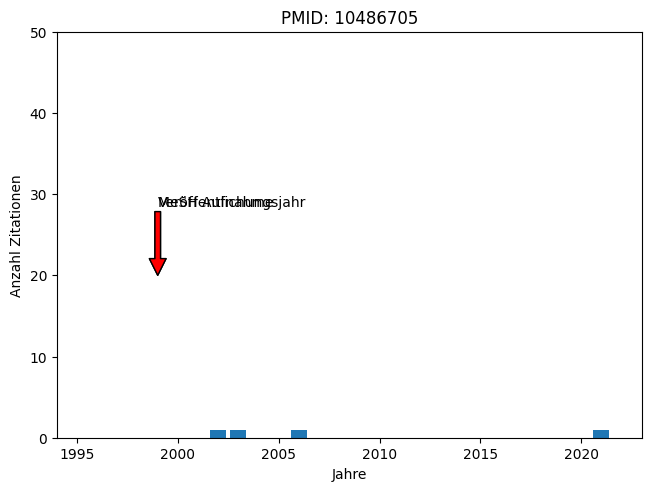

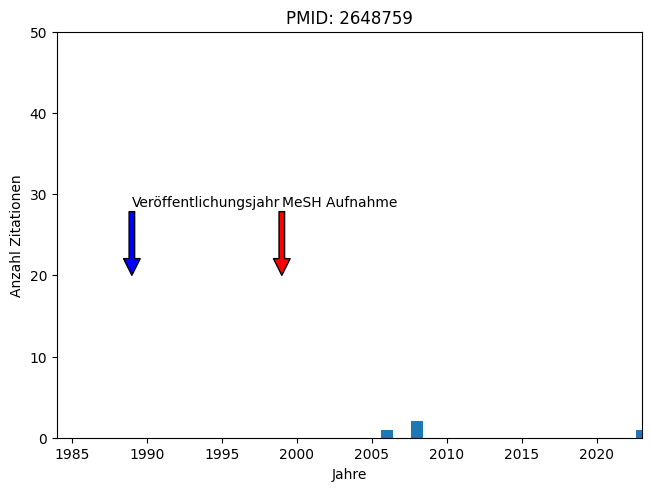

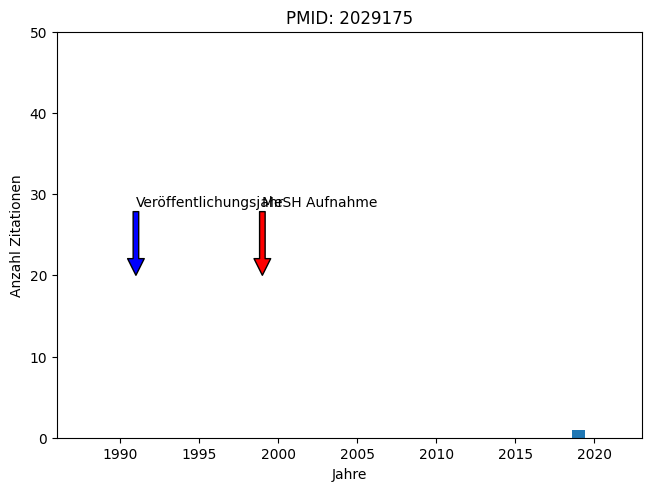

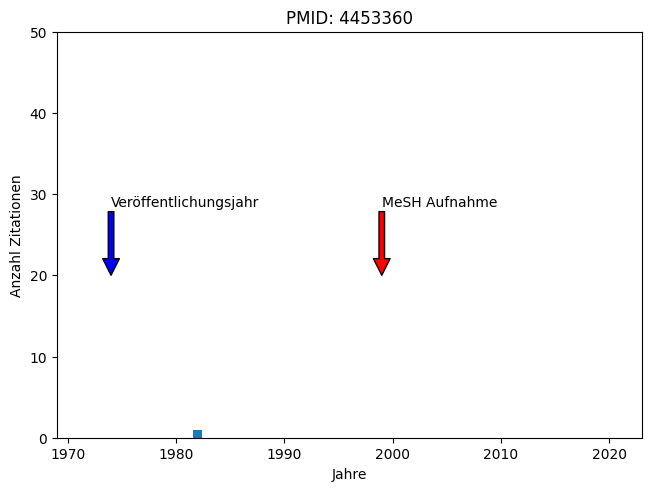

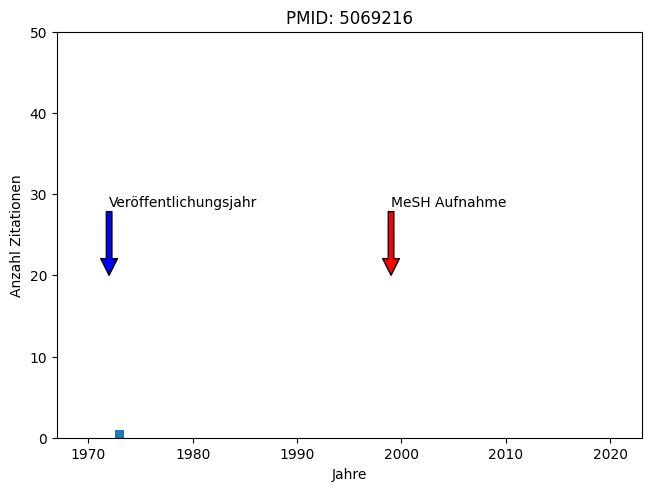

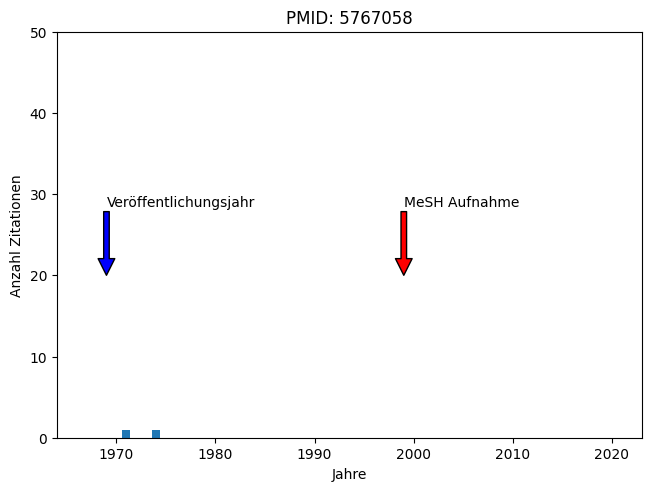

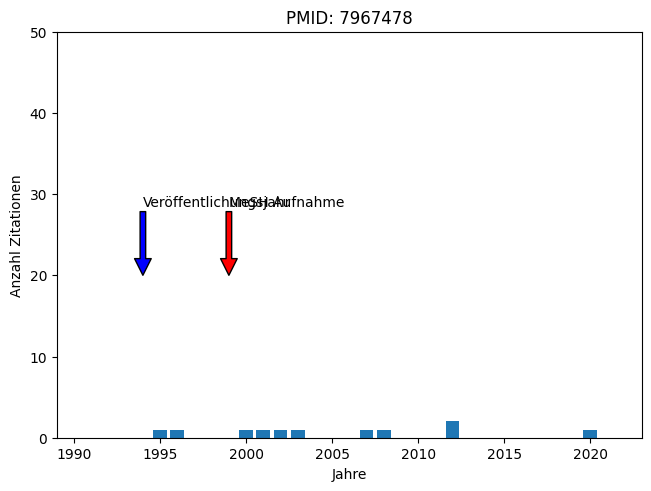

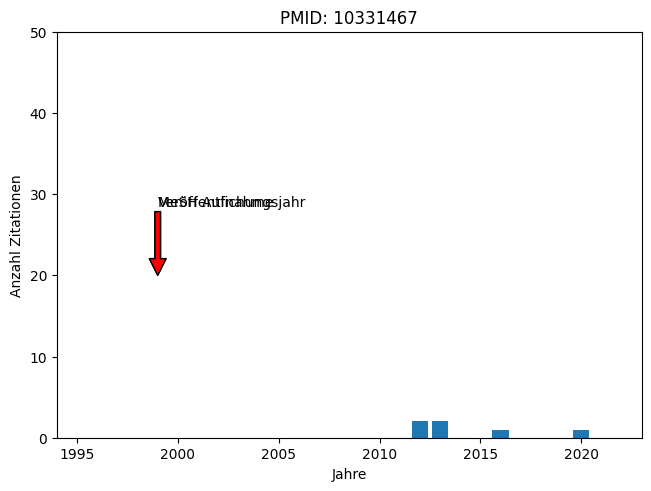

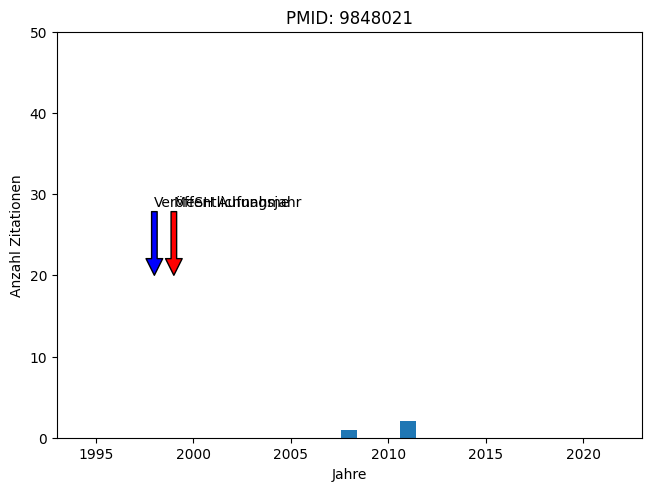

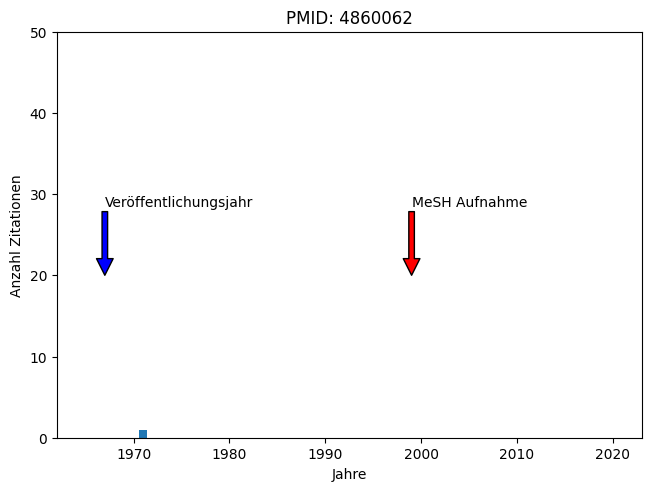

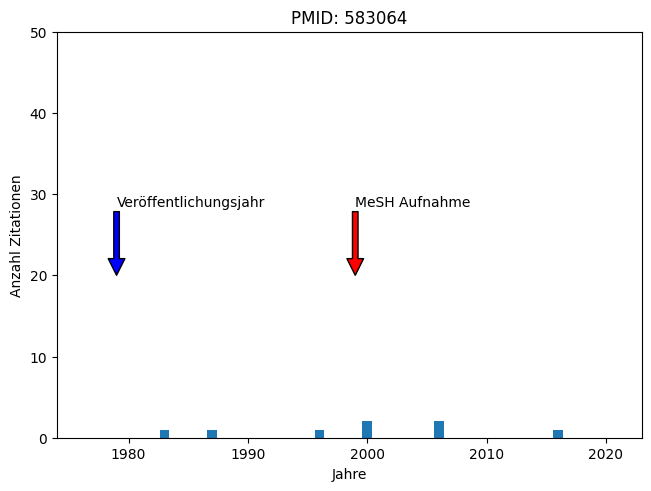

In [28]:
for pmid in pmids_vis:
    # print("PMID: ", pmid)
    cur.execute("SELECT Jahr, Anzahl FROM Zitationen WHERE PMID = '" + str(pmid)+ "'")
    data = cur.fetchall()
    jahre = [x[0] for x in data]
    anzahl = [x[1] for x in data]
    cur.execute("SELECT pubyear FROM Dokumente WHERE PMID = '" + str(pmid)+ "'")
    data = cur.fetchall()
    pubDate = data[0][0]
    cur.execute("SELECT jahr FROM Mesh WHERE UI = '" + str(meshs[meshIndex_vis])+ "'")
    data = cur.fetchall()
    meshDate = data[0][0]
    if len(jahre) != 0:
        fig, ax = plt.subplots(layout="constrained")
        ax.set_ylabel("Anzahl Zitationen")
        ax.set_xlabel("Jahre")
        ax.set_title("PMID: " + str(pmid))
        ax.set_xlim(min(pubDate, meshDate)-5, 2023)
        ax.set_ylim(0, 50)
        ax.bar(jahre, anzahl)
        ax.annotate("Veröffentlichungsjahr",
            xy=(pubDate, 20), 
            xycoords="data",
            xytext=(0, 50),
            textcoords="offset points", 
            arrowprops=dict(facecolor="blue"))
        ax.annotate("MeSH Aufnahme",
            xy=(meshDate, 20), 
            xycoords="data",
            xytext=(0, 50),
            textcoords="offset points", 
            arrowprops=dict(facecolor="red"))
        ax.plot()